In [5]:
import os
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [6]:
# 폰트 경로 설정 (Windows)
font_path = r'C:\Windows\Fonts\NanumGothic.ttf'  # 경로를 적절하게 수정할 수 있습니다.

# 폰트가 존재하는지 확인
if os.path.exists(font_path):
    fe = fm.FontEntry(fname=font_path, name='NanumGothic')
    fm.fontManager.ttflist.insert(0, fe)  # Matplotlib에 폰트 추가n

    plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'})  # 폰트 설정
else:
    print("폰트 파일을 찾을 수 없습니다. 경로를 확인하세요.")

In [7]:
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [8]:
merged_path = 'ML_Project/data/output_final.csv'

df_merged = pd.read_csv(merged_path)


In [9]:
print("결측치가 100만개 이상인 변수들 :", list(df_merged.columns[df_merged.isnull().sum() >= 1000000]))

결측치가 100만개 이상인 변수들 : ['해제사유발생일', '단지소개기존clob', 'k-135㎡초과', 'k-홈페이지', 'k-등록일자']


In [10]:
# 결측치 100만개 이상 삭제
columns_to_delete = list(df_merged.columns[df_merged.isnull().sum() >= 1000000])
df_merged = df_merged.drop(columns=columns_to_delete)

In [11]:
print("결측치가 100만개 이상인 변수들 :", list(df_merged.columns[df_merged.isnull().sum() >= 1000000]))

결측치가 100만개 이상인 변수들 : []


In [12]:
# train 데이터만 추출
train_select = df_merged[df_merged['is_test'] == 0]
test_select = df_merged[df_merged['is_test'] == 1]

In [13]:
display(df_merged['도로명'].value_counts())

도로명
올림픽로 435         4372
솔샘로 174          4049
송파대로 345         3668
성북로4길 52         3519
양재대로 1340        3369
                 ... 
마들로 550             1
광나루로39길 11          1
한강대로62길 45-25       1
사평대로6길 54           1
뚝섬로52길 7            1
Name: count, Length: 9245, dtype: int64

In [14]:
display(df_merged['구'].value_counts())

구
노원구     115837
송파구      74444
강남구      69656
강서구      67041
강동구      62425
구로구      57983
성북구      57160
양천구      54441
서초구      53553
도봉구      52872
영등포구     48097
동작구      40867
마포구      40810
동대문구     40068
성동구      39831
은평구      38664
중랑구      37303
관악구      36243
서대문구     33272
광진구      22252
강북구      22137
용산구      20682
금천구      19738
중구       13534
종로구       9184
Name: count, dtype: int64

In [51]:
# '구'별 'target'의 평균 계산하여 새로운 데이터프레임 생성
gu_target_mean_df = train_select.groupby('구', as_index=False)['target'].mean()
gu_target_mean_df.rename(columns={'target': 'Target_구'}, inplace=True)

# target_mean을 정수형으로 변환
gu_target_mean_df['Target_구'] = gu_target_mean_df['Target_구']

# 결과 출력
print(gu_target_mean_df)

       구       Target_구
0    강남구  114847.461503
1    강동구   54402.872801
2    강북구   38316.975201
3    강서구   44215.453701
4    관악구   41954.133039
5    광진구   67158.379293
6    구로구   38605.012447
7    금천구   33709.248647
8    노원구   33870.444730
9    도봉구   31924.613711
10  동대문구   45194.761822
11   동작구   60936.451058
12   마포구   64445.226137
13  서대문구   49082.573688
14   서초구  113608.653390
15   성동구   68924.389400
16   성북구   45117.779038
17   송파구   83868.032920
18   양천구   59042.132927
19  영등포구   56137.342464
20   용산구  105876.961900
21   은평구   43721.691848
22   종로구   57674.032963
23    중구   62084.985733
24   중랑구   35195.762819


In [52]:
train_select = pd.merge(train_select, gu_target_mean_df, on='구', how='left')


train_select.head(5)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,기준금리,가장 가까운 지하철역까지의 거리,가장 가까운 버스 정류장까지의 거리,500m 이내 지하철역 수,500m 이내 버스 정류장 수,Target_구
0,45,45.0,0.0,우림루미아트,84.57,200701,1,7,2003,명일로26길 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.148513,37.542270,NaN,28000.0,0,강동구,길동,4.5,613.637844,143.225136,0,12,54402.872801
1,495,495.0,0.0,동부,84.99,200701,1,2,1999,신내로7가길 31,,-,-,아파트,24944110.0,24325065.0,분양,위탁관리,혼합식,개별난방,2.0,368.0,동부건설,영건(주),1999-04-29 00:00:00.0,43503.0,27073.0,36735.0,184.0,140.0,44.0,2023-09-23 08:26:23.0,907-00-32615-1,위탁,단일계약,위탁,835.81,392.0,의무,2015-12-02 10:51:05.0,Y,N,127.093838,37.602064,2013-03-07 09:46:28.0,26900.0,0,중랑구,상봉동,4.5,326.825738,192.739216,1,26,35195.762819
2,193-1,193.0,1.0,면목한신,45.44,200701,1,5,1987,중랑천로 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.075465,37.587504,NaN,11500.0,0,중랑구,면목동,4.5,824.449810,93.069097,0,28,35195.762819
3,42,42.0,0.0,동답한신,59.22,200701,1,7,1992,답십리로 210-30,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.062579,37.570810,NaN,18400.0,0,동대문구,답십리동,4.5,981.699673,186.615160,0,16,45194.761822
4,456-2,456.0,2.0,하이브,59.97,200701,1,8,2006,진황도로 100,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.137297,37.535581,NaN,21100.0,0,강동구,길동,4.5,343.303909,103.673632,2,21,54402.872801


In [53]:
# Target_도로명 및 Target_구 log변환

train_select['Target_구'] = np.log1p(train_select['Target_구'])

In [54]:
""" Target 인코딩 스무싱 """

' Target 인코딩 스무싱 '

In [55]:
# 'Target_구' 데이터 가져오기
data_district = train_select['Target_구'].values

# 최적 알파 값 설정
optimal_alpha_district = 1  # 이전에 찾은 최적 알파 값

# 지수 스무싱 적용
smoothed_district = [data_district[0]]  # 첫 번째 값으로 초기화
for t in range(1, len(data_district)):
    smoothed_value = optimal_alpha_district * data_district[t] + (1 - optimal_alpha_district) * smoothed_district[-1]
    smoothed_district.append(smoothed_value)

# 스무싱된 데이터를 데이터프레임에 추가
train_select['Smoothed_Target_구'] = smoothed_district


In [56]:
# import pandas as pd
# import numpy as np
# import category_encoders as ce
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

# # 1. 데이터 로드
# # 이미 'train_select' 데이터프레임이 로드되어 있다고 가정합니다.
# # 예시:
# # train_select = pd.read_csv('your_data.csv')  # 실제 데이터 로드 방식에 맞게 수정

# # 2. 데이터 분할 (학습 세트와 테스트 세트)
# X = train_select.drop(['target', 'is_test'], axis=1)  # 'target'과 'is_test'는 제외
# y = train_select['target']  # 실제 타겟 변수

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.05, random_state=42
# )

# # 3. 지수 스무딩 함수 정의
# def exponential_smoothing(data, alpha, initial_value=None):
#     """
#     지수 스무딩을 적용하는 함수.

#     Parameters:
#     - data (array-like): 스무딩을 적용할 데이터.
#     - alpha (float): 스무딩 파라미터 (0 < alpha < 1).
#     - initial_value (float, optional): 초기 스무딩 값. 기본값은 첫 번째 데이터 포인트.

#     Returns:
#     - smoothed_data (list): 스무딩된 데이터.
#     """
#     if initial_value is None:
#         smoothed_data = [data[0]]  # 첫 번째 값으로 초기화
#     else:
#         smoothed_data = [initial_value]
#     for t in range(1, len(data)):
#         smoothed_value = alpha * data[t] + (1 - alpha) * smoothed_data[-1]
#         smoothed_data.append(smoothed_value)
#     return smoothed_data

# # 4. 학습 세트에 지수 스무딩 적용
# optimal_alpha_district = 0.02  # 이전에 찾은 최적 알파 값

# data_district_train = X_train['Target_구'].values
# smoothed_district_train = exponential_smoothing(data_district_train, optimal_alpha_district)
# X_train = X_train.copy()  # SettingWithCopy 경고 방지
# X_train['Smoothed_Target_구'] = smoothed_district_train

# # 5. 테스트 세트에 지수 스무딩 적용
# # 학습 세트의 마지막 스무싱 값을 초기값으로 사용
# last_smoothed_value = smoothed_district_train[-1]
# data_district_test = X_test['Target_구'].values
# smoothed_district_test = exponential_smoothing(data_district_test, optimal_alpha_district, initial_value=last_smoothed_value)
# X_test = X_test.copy()
# X_test['Smoothed_Target_구'] = smoothed_district_test

# # 6. 타겟 인코딩 적용
# # 범주형 피처 식별 (예: object 또는 category 타입)
# categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# # 스무딩 파라미터가 낮은 경우 (k=1)
# encoder_low = ce.TargetEncoder(smoothing=1)
# X_train_encoded_low = encoder_low.fit_transform(X_train[categorical_features], y_train)
# X_test_encoded_low = encoder_low.transform(X_test[categorical_features])

# # 스무딩 파라미터가 높은 경우 (k=10)
# encoder_high = ce.TargetEncoder(smoothing=10)
# X_train_encoded_high = encoder_high.fit_transform(X_train[categorical_features], y_train)
# X_test_encoded_high = encoder_high.transform(X_test[categorical_features])

# # 타겟 인코딩된 피처를 원본 데이터에 추가
# X_train_encoded_low = X_train.drop(categorical_features, axis=1).join(X_train_encoded_low)
# X_test_encoded_low = X_test.drop(categorical_features, axis=1).join(X_test_encoded_low)

# X_train_encoded_high = X_train.drop(categorical_features, axis=1).join(X_train_encoded_high)
# X_test_encoded_high = X_test.drop(categorical_features, axis=1).join(X_test_encoded_high)

# # 7. 스케일링
# # 스케일링할 연속형 피처 선택 (범주형 제외)
# continuous_columns = X_train_encoded_low.select_dtypes(include=['int64', 'float64']).columns.tolist()
# columns_to_exclude = ['target', 'is_test']  # 이미 제외됨
# columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

# # 스케일러 초기화 및 학습 세트에 피팅
# scaler_low = MinMaxScaler()
# X_train_encoded_low[columns_to_scale] = scaler_low.fit_transform(X_train_encoded_low[columns_to_scale])

# # 테스트 세트에 스케일링 적용
# X_test_encoded_low[columns_to_scale] = scaler_low.transform(X_test_encoded_low[columns_to_scale])

# # 높은 스무딩에도 동일하게 스케일링
# scaler_high = MinMaxScaler()
# X_train_encoded_high[columns_to_scale] = scaler_high.fit_transform(X_train_encoded_high[columns_to_scale])
# X_test_encoded_high[columns_to_scale] = scaler_high.transform(X_test_encoded_high[columns_to_scale])

# # 8. 모델 학습 및 평가
# # 모델 학습 및 평가 (낮은 스무딩)
# model_low = RandomForestRegressor(random_state=42, n_jobs=-1)
# model_low.fit(X_train_encoded_low, y_train)
# predictions_low = model_low.predict(X_test_encoded_low)
# rmse_low = mean_squared_error(y_test, predictions_low, squared=False)
# print(f"RMSE with low smoothing (k=1): {rmse_low}")

# # 모델 학습 및 평가 (높은 스무딩)
# model_high = RandomForestRegressor(random_state=42, n_jobs=-1)
# model_high.fit(X_train_encoded_high, y_train)
# predictions_high = model_high.predict(X_test_encoded_high)
# rmse_high = mean_squared_error(y_test, predictions_high, squared=False)
# print(f"RMSE with high smoothing (k=10): {rmse_high}")


In [57]:
train_select.head(5)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,기준금리,가장 가까운 지하철역까지의 거리,가장 가까운 버스 정류장까지의 거리,500m 이내 지하철역 수,500m 이내 버스 정류장 수,Target_구,Smoothed_Target_구
0,45,45.0,0.0,우림루미아트,84.57,200701,1,7,2003,명일로26길 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.148513,37.542270,NaN,28000.0,0,강동구,길동,4.5,613.637844,143.225136,0,12,10.904191,10.904191
1,495,495.0,0.0,동부,84.99,200701,1,2,1999,신내로7가길 31,,-,-,아파트,24944110.0,24325065.0,분양,위탁관리,혼합식,개별난방,2.0,368.0,동부건설,영건(주),1999-04-29 00:00:00.0,43503.0,27073.0,36735.0,184.0,140.0,44.0,2023-09-23 08:26:23.0,907-00-32615-1,위탁,단일계약,위탁,835.81,392.0,의무,2015-12-02 10:51:05.0,Y,N,127.093838,37.602064,2013-03-07 09:46:28.0,26900.0,0,중랑구,상봉동,4.5,326.825738,192.739216,1,26,10.468709,10.468709
2,193-1,193.0,1.0,면목한신,45.44,200701,1,5,1987,중랑천로 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.075465,37.587504,NaN,11500.0,0,중랑구,면목동,4.5,824.449810,93.069097,0,28,10.468709,10.468709
3,42,42.0,0.0,동답한신,59.22,200701,1,7,1992,답십리로 210-30,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.062579,37.570810,NaN,18400.0,0,동대문구,답십리동,4.5,981.699673,186.615160,0,16,10.718759,10.718759
4,456-2,456.0,2.0,하이브,59.97,200701,1,8,2006,진황도로 100,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.137297,37.535581,NaN,21100.0,0,강동구,길동,4.5,343.303909,103.673632,2,21,10.904191,10.904191


In [58]:
# del train_select['Target_도로명']
del train_select['Target_구']

In [59]:
# train_select에서 구와 Smoothed_Target_구 컬럼을 추출하여 매핑용 딕셔너리 생성
gu_to_target = dict(zip(train_select['구'], train_select['Smoothed_Target_구']))

# test_select의 구 값에 대해 Smoothed_Target_구 값을 매핑하여 추가
test_select['Smoothed_Target_구'] = test_select['구'].map(gu_to_target)

# 만약 test 데이터에 train 데이터에 없는 구 값이 있다면 NaN 처리
test_select['Smoothed_Target_구'] = test_select['Smoothed_Target_구'].fillna(np.nan)


In [60]:
test_select.head()

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,기준금리,가장 가까운 지하철역까지의 거리,가장 가까운 버스 정류장까지의 거리,500m 이내 지하철역 수,500m 이내 버스 정류장 수,Smoothed_Target_구
1118822,7,7.0,0.0,장미1,82.45,202307,1,1,1979,올림픽로35길 104,20230913,중개거래,서울 송파구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.099281,37.518885,NaN,NaN,1,송파구,신천동,3.5,448.158067,227.802614,1,12,11.337012
1118823,7,7.0,0.0,장미1,120.00,202307,1,7,1979,올림픽로35길 104,,중개거래,서울 송파구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.099281,37.518885,NaN,NaN,1,송파구,신천동,3.5,448.158067,227.802614,1,12,11.337012
1118824,7-3,7.0,3.0,래미안삼성2차,101.38,202307,1,8,2007,선릉로130길 20,,중개거래,서울 강남구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.043436,37.516151,NaN,NaN,1,강남구,삼성동,3.5,223.977340,141.096595,2,13,11.651369
1118825,639,639.0,0.0,보람1단지,44.33,202307,1,15,1988,한글비석로 479,20230906,중개거래,서울 노원구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.064397,37.662782,NaN,NaN,1,노원구,상계동,3.5,639.383866,137.357341,0,42,10.430328
1118826,33,33.0,0.0,호수임광,84.87,202307,1,8,1995,송파대로48길 34,20230920,중개거래,서울 송파구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.107151,37.510354,NaN,NaN,1,송파구,송파동,3.5,447.627289,48.205521,1,17,11.337012


In [61]:
concat_select = pd.concat([train_select, test_select])  

In [62]:
concat_select.shape

(1128094, 55)

In [63]:
# 결측치가 있는 수치형 변수 목록
missing_columns = [
    'k-전체동수', 'k-전체세대수', 'k-연면적', 'k-주거전용면적', 
    'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 
    'k-85㎡~135㎡이하', '주차대수','건축면적','k-관리비부과면적'
]

# 각 변수에 대해 is_missing 컬럼 생성
for col in missing_columns:
    concat_select[f'{col}_is_missing'] = concat_select[col].isnull().astype('int64')

# 각 결측치를 median 값으로 채움
for col in missing_columns:
    concat_select[col].fillna(concat_select[col].median(), inplace=True)

In [64]:
import pandas as pd

# is_missing 변수 리스트
missing_cols = [
    'k-전체동수_is_missing',
    'k-전체세대수_is_missing',
    'k-연면적_is_missing',
    'k-주거전용면적_is_missing',
    'k-전용면적별세대현황(60㎡이하)_is_missing',
    'k-전용면적별세대현황(60㎡~85㎡이하)_is_missing',
    'k-85㎡~135㎡이하_is_missing',
    '주차대수_is_missing',
    '건축면적_is_missing',
    'k-관리비부과면적_is_missing'
]

# 총 결측치 개수 변수 생성
concat_select['continuous_missing_count'] = concat_select[missing_cols].sum(axis=1)

# 하나 이상의 결측치 존재 여부 변수 제거
concat_select.drop(columns=missing_cols, inplace=True)


In [65]:
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.max_rows', None)  
concat_select.sample(n=5)

,번지,본번,부번,아파트명,전용면적(㎡),계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,기준금리,가장 가까운 지하철역까지의 거리,가장 가까운 버스 정류장까지의 거리,500m 이내 지하철역 수,500m 이내 버스 정류장 수,Smoothed_Target_구,continuous_missing_count
203391,14,14.0,0.0,문래두산위브,65.4600,201004,17,1,1988,선유로9나길 8,,-,-,아파트,0226724090,226724098.0,분양,위탁관리,복도식,개별난방,3.0,383.0,두산건설,두산사우주택조합,1988-11-08 00:00:00.0,38376.0,27231.0,37470.0,0.0,383.0,0.0,2023-09-26 12:45:14.0,90700326261,위탁,종합계약,위탁,0.00,350.0,의무,2013-06-23 11:57:47.0,Y,N,126.885821,37.516878,2013-03-07 09:46:46.0,25000.0,0,영등포구,문래동5가,2.00,394.198211,67.901944,1,22,10.935574,0
1088256,1285,1285.0,0.0,동아불암,84.9000,202112,10,7,1999,덕릉로 780,,중개거래,서울 노원구,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.079689,37.666956,NaN,77000.0,0,노원구,상계동,1.00,371.932304,94.431001,1,11,10.430328,10
452843,720-18,720.0,18.0,방학동삼성래미안1,118.3810,201409,3,22,2002,마들로 646,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.047338,37.666945,NaN,52400.0,0,도봉구,방학동,2.25,277.341452,106.372470,1,25,10.371164,10
368880,474,474.0,0.0,미아동부센트레빌,84.9300,201308,26,14,2006,숭인로7가길 37,,-,-,아파트,29805278.0,29805279.0,분양,위탁관리,계단식,개별난방,8.0,480.0,동부건설,미아제10구역주택재개발조합,2006-04-25 00:00:00.0,67166.0,36746.0,46592.0,192.0,262.0,26.0,2023-09-24 08:14:22.0,90700279881,위탁,단일계약,위탁,0.00,566.0,의무,2016-10-26 14:54:23.0,Y,N,127.025728,37.613682,2013-03-07 09:46:48.0,42500.0,0,강북구,미아동,2.50,384.139178,186.517762,1,33,10.553674,0
1038998,527,527.0,0.0,도곡렉슬,114.9931,202012,3,5,2006,선릉로 221,,-,-,아파트,025774505,025774559,분양,위탁관리,계단식,지역난방,34.0,3002.0,"현대,쌍용,GS",도곡주공재건축조합,2006-01-27 00:00:00.0,553661.0,298679.0,379722.0,601.0,936.0,1402.0,2023-09-20 21:31:32.0,91201768311,위탁,종합계약,위탁,20457.82,4443.0,의무,2013-06-23 14:21:13.0,Y,N,127.048985,37.493029,2013-03-07 09:46:20.0,319000.0,0,강남구,도곡동,0.50,494.817591,152.515235,1,16,11.651369,0


In [66]:
import pandas as pd


# bus 및 subway 변수 리스트
bus_subway_cols = [
    '500m 이내 지하철역 수',
    '500m 이내 버스 정류장 수'
]

# 총 결측치 개수 변수 생성
concat_select['500m_이내_대중교통_갯수'] = concat_select[bus_subway_cols].sum(axis=1)

# 하나 이상의 결측치 존재 여부 변수 제거
concat_select.drop(columns=bus_subway_cols, inplace=True)


In [67]:
# 층이 지하일 경우, 양수로 바꾸고 옆에 지하인지 아닌지 확인하는 변수 생성 
concat_select['지하여부'] = concat_select['층'].apply(lambda x: 1 if x < 0 else 0)  # 1이면 지하, 0이면 지상
concat_select['층'] = concat_select['층'].abs()  # 층 값을 양수로 변환


In [68]:
import numpy as np
from scipy import stats

# 전용면적(㎡) 로그 변환
concat_select['전용면적_log'] = np.log1p(concat_select['전용면적(㎡)'])

def remove_outliers_iqr(df, column):
    train_df = df[df['is_test'] == 0]
    test_df = df[df['is_test'] == 1]
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1 * IQR
    train_df = train_df[(train_df[column] >= lower) & (train_df[column] <= upper)]
    return pd.concat([train_df, test_df])

# 이상치 제거 적용
concat_select = remove_outliers_iqr(concat_select, '전용면적_log')


In [69]:
del concat_select['전용면적(㎡)']

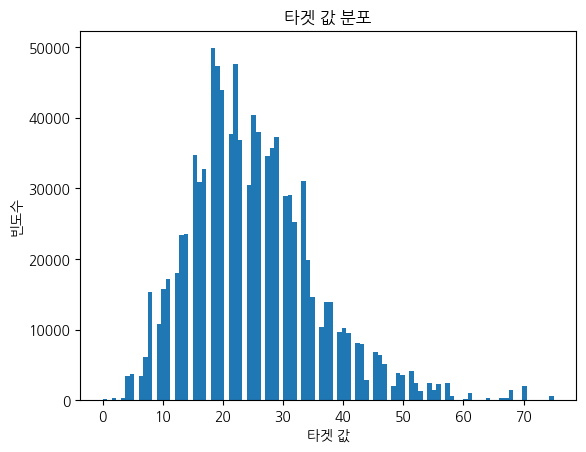

In [70]:
import matplotlib.pyplot as plt
plt.hist(concat_select['500m_이내_대중교통_갯수'], bins=100)
plt.title('타겟 값 분포')
plt.xlabel('타겟 값')
plt.ylabel('빈도수')
plt.show()

In [71]:
concat_select.shape

(1006924, 56)

In [72]:
concat_select.head()

,번지,본번,부번,아파트명,계약년월,계약일,층,건축년도,도로명,등기신청일자,거래유형,중개사소재지,"k-단지분류(아파트,주상복합등등)",k-전화번호,k-팩스번호,k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-전체세대수,k-건설사(시공사),k-시행사,k-사용검사일-사용승인일,k-연면적,k-주거전용면적,k-관리비부과면적,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,k-수정일자,고용보험관리번호,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,단지승인일,사용허가여부,관리비 업로드,좌표X,좌표Y,단지신청일,target,is_test,구,동,기준금리,가장 가까운 지하철역까지의 거리,가장 가까운 버스 정류장까지의 거리,Smoothed_Target_구,continuous_missing_count,500m_이내_대중교통_갯수,지하여부,전용면적_log
0,45,45.0,0.0,우림루미아트,200701,1,7,2003,명일로26길 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.148513,37.542270,NaN,28000.0,0,강동구,길동,4.5,613.637844,143.225136,10.904191,10,12,0,4.449335
1,495,495.0,0.0,동부,200701,1,2,1999,신내로7가길 31,,-,-,아파트,24944110.0,24325065.0,분양,위탁관리,혼합식,개별난방,2.0,368.0,동부건설,영건(주),1999-04-29 00:00:00.0,43503.0,27073.0,36735.0,184.0,140.0,44.0,2023-09-23 08:26:23.0,907-00-32615-1,위탁,단일계약,위탁,835.81,392.0,의무,2015-12-02 10:51:05.0,Y,N,127.093838,37.602064,2013-03-07 09:46:28.0,26900.0,0,중랑구,상봉동,4.5,326.825738,192.739216,10.468709,0,27,0,4.454231
2,193-1,193.0,1.0,면목한신,200701,1,5,1987,중랑천로 20,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.075465,37.587504,NaN,11500.0,0,중랑구,면목동,4.5,824.449810,93.069097,10.468709,10,28,0,3.838161
3,42,42.0,0.0,동답한신,200701,1,7,1992,답십리로 210-30,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.062579,37.570810,NaN,18400.0,0,동대문구,답십리동,4.5,981.699673,186.615160,10.718759,10,16,0,4.098005
4,456-2,456.0,2.0,하이브,200701,1,8,2006,진황도로 100,,-,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,768.0,NaN,NaN,NaN,102624.0,60505.0,78125.0,226.0,258.0,64.0,NaN,NaN,NaN,NaN,NaN,1735.00,683.0,NaN,NaN,NaN,NaN,127.137297,37.535581,NaN,21100.0,0,강동구,길동,4.5,343.303909,103.673632,10.904191,10,23,0,4.110382


In [73]:
columns_to_delete = ['번지','본번','부번','구','k-전화번호', 'k-팩스번호', 
                     '고용보험관리번호','k-사용검사일-사용승인일', 'k-수정일자', '단지승인일', '단지신청일',
                     '사용허가여부', '관리비 업로드','계약년월','계약일','등기신청일자','중개사소재지']

# 데이터프레임에서 필요 없는 해당 열들 제거
concat_select.drop(columns=columns_to_delete, inplace=True)

In [74]:
# k-전체세대수 (VIF = 2491.47) 거거
del concat_select['k-전체세대수']
# k-주거전용면적 (VIF = 277.92)
del concat_select['k-주거전용면적']
# k-관리비부과면적 (VIF = 57.98)
del concat_select['k-관리비부과면적']
del concat_select['가장 가까운 버스 정류장까지의 거리']
del concat_select['가장 가까운 지하철역까지의 거리']
del concat_select['건축년도']
del concat_select['k-연면적']

In [75]:
concat_select.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006924 entries, 0 to 1128093
Data columns (total 17 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   층                         1006924 non-null  int64  
 1   k-전체동수                    1006924 non-null  float64
 2   k-전용면적별세대현황(60㎡이하)        1006924 non-null  float64
 3   k-전용면적별세대현황(60㎡~85㎡이하)    1006924 non-null  float64
 4   k-85㎡~135㎡이하              1006924 non-null  float64
 5   건축면적                      1006924 non-null  float64
 6   주차대수                      1006924 non-null  float64
 7   좌표X                       1006924 non-null  float64
 8   좌표Y                       1006924 non-null  float64
 9   target                    997652 non-null   float64
 10  is_test                   1006924 non-null  int64  
 11  기준금리                      1006924 non-null  float64
 12  Smoothed_Target_구         1006924 non-null  float64
 13  continuous_missing_count  100692

In [76]:
# is_missing, 지하여부는 뺌
# columns_to_scale = [
#     '전용면적_log', '층', 'k-전체동수',
#     'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)',
#     'k-85㎡~135㎡이하', '주차대수', '기준금리',
#     '가장 가까운 지하철역까지의 거리', '가장 가까운 버스 정류장까지의 거리',
#     '500m 이내 지하철역 수', '500m 이내 버스 정류장 수'
# ]

# # MinMaxScaler 초기화
# scaler = MinMaxScaler()

# # 선택된 연속형 변수들에 스케일러 적용
# continuous_columns = concat_select.select_dtypes(include=['int64', 'float64']).columns
# concat_select[continuous_columns] = scaler.fit_transform(concat_select[continuous_columns])


In [77]:
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.max_rows', None)  
concat_select.head(10)

,아파트명,층,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-건설사(시공사),k-시행사,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,좌표X,좌표Y,target,is_test,동,기준금리,Smoothed_Target_구,continuous_missing_count,500m_이내_대중교통_갯수,지하여부,전용면적_log
0,우림루미아트,7,명일로26길 20,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.148513,37.542270,28000.0,0,길동,4.5,10.904191,10,12,0,4.449335
1,동부,2,신내로7가길 31,-,아파트,분양,위탁관리,혼합식,개별난방,2.0,동부건설,영건(주),184.0,140.0,44.0,위탁,단일계약,위탁,835.81,392.0,의무,127.093838,37.602064,26900.0,0,상봉동,4.5,10.468709,0,27,0,4.454231
2,면목한신,5,중랑천로 20,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.075465,37.587504,11500.0,0,면목동,4.5,10.468709,10,28,0,3.838161
3,동답한신,7,답십리로 210-30,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.062579,37.570810,18400.0,0,답십리동,4.5,10.718759,10,16,0,4.098005
4,하이브,8,진황도로 100,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.137297,37.535581,21100.0,0,길동,4.5,10.904191,10,23,0,4.110382
5,도봉파크빌2,1,마들로 835,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.050721,37.684371,23500.0,0,도봉동,4.5,10.371164,10,22,0,4.446807
6,정릉우성,10,북악산로 813,-,아파트,분양,자치관리,혼합식,개별난방,5.0,우성건설,한국데이타통신(주)제3직장주택조합외 11개조합,187.0,599.0,37.0,직영,단일계약,위탁,0.00,708.0,의무,127.015681,37.601073,31500.0,0,정릉동,4.5,10.717054,0,44,0,4.454231
7,벽산,15,양천로47길 118,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,126.837836,37.575733,30000.0,0,마곡동,4.5,10.696852,10,8,0,4.110546
8,서초코아,1,남부순환로317길 18-16,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.011078,37.480314,42500.0,0,서초동,4.5,11.640524,10,22,0,4.569854
10,래미안월곡,18,오패산로 90,-,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,226.0,258.0,64.0,NaN,NaN,NaN,1735.00,683.0,NaN,127.036873,37.610440,70000.0,0,하월곡동,4.5,10.717054,10,45,0,4.750810


In [78]:
categorical_columns = concat_select.select_dtypes(include=['object']).columns

In [79]:
concat_select[categorical_columns].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1006924 entries, 0 to 1128093
Data columns (total 15 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   아파트명                 1005374 non-null  object
 1   도로명                  1006924 non-null  object
 2   거래유형                 1006924 non-null  object
 3   k-단지분류(아파트,주상복합등등)   227997 non-null   object
 4   k-세대타입(분양형태)         228968 non-null   object
 5   k-관리방식               228968 non-null   object
 6   k-복도유형               228659 non-null   object
 7   k-난방방식               228968 non-null   object
 8   k-건설사(시공사)           227598 non-null   object
 9   k-시행사                227416 non-null   object
 10  경비비관리형태              227923 non-null   object
 11  세대전기계약방법             221132 non-null   object
 12  청소비관리형태              227733 non-null   object
 13  기타/의무/임대/임의=1/2/3/4  228968 non-null   object
 14  동                    1006924 non-null  object
dtypes: object(15)
memory

In [80]:
# 각 범주형 변수에 대해 결측치를 최빈값으로 채우고, 1.0 컬럼 추가
for col in categorical_columns:
    # 결측치 여부를 나타내는 is_missing 컬럼 생성 (결측치가 있으면 'Missing', 아니면 'Not Missing')
    concat_select[f'{col}_is_missing'] = concat_select[col].isnull().apply(lambda x: 1 if x else 0)
    
    # 최빈값으로 결측치 채우기
    most_frequent = concat_select[col].mode()[0]  # 최빈값
    concat_select[col].fillna(most_frequent, inplace=True)


In [81]:
import pandas as pd

# is_missing 변수 리스트
categorical_missing_cols = [
    '아파트명_is_missing',
    '도로명_is_missing',
    '거래유형_is_missing',
    'k-단지분류(아파트,주상복합등등)_is_missing',
    'k-세대타입(분양형태)_is_missing',
    'k-관리방식_is_missing',
    'k-복도유형_is_missing',
    'k-난방방식_is_missing',
    'k-건설사(시공사)_is_missing',
    'k-시행사_is_missing',
    '경비비관리형태_is_missing',
    '세대전기계약방법_is_missing',
    '청소비관리형태_is_missing',
    '기타/의무/임대/임의=1/2/3/4_is_missing',
    '동_is_missing'
]


# 총 결측치 개수 변수 생성
concat_select['categorical_missing_count'] = concat_select[categorical_missing_cols].sum(axis=1)

# 하나 이상의 결측치 존재 여부 변수 제거
concat_select.drop(columns=categorical_missing_cols, inplace=True)


In [82]:
concat_select.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1006924 entries, 0 to 1128093
Data columns (total 33 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   아파트명                       1006924 non-null  object 
 1   층                          1006924 non-null  int64  
 2   도로명                        1006924 non-null  object 
 3   거래유형                       1006924 non-null  object 
 4   k-단지분류(아파트,주상복합등등)         1006924 non-null  object 
 5   k-세대타입(분양형태)               1006924 non-null  object 
 6   k-관리방식                     1006924 non-null  object 
 7   k-복도유형                     1006924 non-null  object 
 8   k-난방방식                     1006924 non-null  object 
 9   k-전체동수                     1006924 non-null  float64
 10  k-건설사(시공사)                 1006924 non-null  object 
 11  k-시행사                      1006924 non-null  object 
 12  k-전용면적별세대현황(60㎡이하)         1006924 non-null  float64
 13  k-전용면적별세대현황(60㎡~8

In [83]:
concat_select.head()

,아파트명,층,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-건설사(시공사),k-시행사,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,좌표X,좌표Y,target,is_test,동,기준금리,Smoothed_Target_구,continuous_missing_count,500m_이내_대중교통_갯수,지하여부,전용면적_log,categorical_missing_count
0,우림루미아트,7,명일로26길 20,-,아파트,분양,위탁관리,계단식,개별난방,10.0,삼성물산,SH공사,226.0,258.0,64.0,위탁,단일계약,위탁,1735.00,683.0,의무,127.148513,37.542270,28000.0,0,길동,4.5,10.904191,10,12,0,4.449335,11
1,동부,2,신내로7가길 31,-,아파트,분양,위탁관리,혼합식,개별난방,2.0,동부건설,영건(주),184.0,140.0,44.0,위탁,단일계약,위탁,835.81,392.0,의무,127.093838,37.602064,26900.0,0,상봉동,4.5,10.468709,0,27,0,4.454231,0
2,면목한신,5,중랑천로 20,-,아파트,분양,위탁관리,계단식,개별난방,10.0,삼성물산,SH공사,226.0,258.0,64.0,위탁,단일계약,위탁,1735.00,683.0,의무,127.075465,37.587504,11500.0,0,면목동,4.5,10.468709,10,28,0,3.838161,11
3,동답한신,7,답십리로 210-30,-,아파트,분양,위탁관리,계단식,개별난방,10.0,삼성물산,SH공사,226.0,258.0,64.0,위탁,단일계약,위탁,1735.00,683.0,의무,127.062579,37.570810,18400.0,0,답십리동,4.5,10.718759,10,16,0,4.098005,11
4,하이브,8,진황도로 100,-,아파트,분양,위탁관리,계단식,개별난방,10.0,삼성물산,SH공사,226.0,258.0,64.0,위탁,단일계약,위탁,1735.00,683.0,의무,127.137297,37.535581,21100.0,0,길동,4.5,10.904191,10,23,0,4.110382,11


In [84]:
# MinMaxScaler 초기화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

continuous_columns = concat_select.select_dtypes(include=['int64', 'float64']).columns
# 선택된 연속형 변수들에 스케일러 적용
columns_to_exclude = ['target', 'is_test']
columns_to_scale = [col for col in continuous_columns if col not in columns_to_exclude]

concat_select[columns_to_scale] = scaler.fit_transform(concat_select[columns_to_scale])

In [85]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006924 entries, 0 to 1128093
Data columns (total 33 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   아파트명                       1006924 non-null  object 
 1   층                          1006924 non-null  float64
 2   도로명                        1006924 non-null  object 
 3   거래유형                       1006924 non-null  object 
 4   k-단지분류(아파트,주상복합등등)         1006924 non-null  object 
 5   k-세대타입(분양형태)               1006924 non-null  object 
 6   k-관리방식                     1006924 non-null  object 
 7   k-복도유형                     1006924 non-null  object 
 8   k-난방방식                     1006924 non-null  object 
 9   k-전체동수                     1006924 non-null  float64
 10  k-건설사(시공사)                 1006924 non-null  object 
 11  k-시행사                      1006924 non-null  object 
 12  k-전용면적별세대현황(60㎡이하)         1006924 non-null  float64
 13  k-전용면적별세대현황(60㎡~8

In [86]:
del concat_select['좌표X']
del concat_select['좌표Y']

In [87]:
concat_select.isnull().sum()

아파트명                            0
층                               0
도로명                             0
거래유형                            0
k-단지분류(아파트,주상복합등등)              0
k-세대타입(분양형태)                    0
k-관리방식                          0
k-복도유형                          0
k-난방방식                          0
k-전체동수                          0
k-건설사(시공사)                      0
k-시행사                           0
k-전용면적별세대현황(60㎡이하)              0
k-전용면적별세대현황(60㎡~85㎡이하)          0
k-85㎡~135㎡이하                    0
경비비관리형태                         0
세대전기계약방법                        0
청소비관리형태                         0
건축면적                            0
주차대수                            0
기타/의무/임대/임의=1/2/3/4             0
target                       9272
is_test                         0
동                               0
기준금리                            0
Smoothed_Target_구               0
continuous_missing_count        0
500m_이내_대중교통_갯수                 0
지하여부                            0
전용면적_log      

In [88]:
concat_select.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1006924 entries, 0 to 1128093
Data columns (total 31 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   아파트명                       1006924 non-null  object 
 1   층                          1006924 non-null  float64
 2   도로명                        1006924 non-null  object 
 3   거래유형                       1006924 non-null  object 
 4   k-단지분류(아파트,주상복합등등)         1006924 non-null  object 
 5   k-세대타입(분양형태)               1006924 non-null  object 
 6   k-관리방식                     1006924 non-null  object 
 7   k-복도유형                     1006924 non-null  object 
 8   k-난방방식                     1006924 non-null  object 
 9   k-전체동수                     1006924 non-null  float64
 10  k-건설사(시공사)                 1006924 non-null  object 
 11  k-시행사                      1006924 non-null  object 
 12  k-전용면적별세대현황(60㎡이하)         1006924 non-null  float64
 13  k-전용면적별세대현황(60㎡~8

In [89]:
pd.set_option('display.max_columns', None)  # 모든 열 표시
pd.set_option('display.max_rows', None)  
concat_select.head(5)

,아파트명,층,도로명,거래유형,"k-단지분류(아파트,주상복합등등)",k-세대타입(분양형태),k-관리방식,k-복도유형,k-난방방식,k-전체동수,k-건설사(시공사),k-시행사,k-전용면적별세대현황(60㎡이하),k-전용면적별세대현황(60㎡~85㎡이하),k-85㎡~135㎡이하,경비비관리형태,세대전기계약방법,청소비관리형태,건축면적,주차대수,기타/의무/임대/임의=1/2/3/4,target,is_test,동,기준금리,Smoothed_Target_구,continuous_missing_count,500m_이내_대중교통_갯수,지하여부,전용면적_log,categorical_missing_count
0,우림루미아트,0.092308,명일로26길 20,-,아파트,분양,위탁관리,계단식,개별난방,0.073171,삼성물산,SH공사,0.045427,0.050273,0.042667,위탁,단일계약,위탁,0.000055,0.056465,의무,28000.0,0,길동,0.842105,0.416360,1.0,0.160000,0.0,0.598782,0.916667
1,동부,0.015385,신내로7가길 31,-,아파트,분양,위탁관리,혼합식,개별난방,0.008130,동부건설,영건(주),0.036985,0.027280,0.029333,위탁,단일계약,위탁,0.000026,0.032407,의무,26900.0,0,상봉동,0.842105,0.076195,0.0,0.360000,0.0,0.600337,0.000000
2,면목한신,0.061538,중랑천로 20,-,아파트,분양,위탁관리,계단식,개별난방,0.073171,삼성물산,SH공사,0.045427,0.050273,0.042667,위탁,단일계약,위탁,0.000055,0.056465,의무,11500.0,0,면목동,0.842105,0.076195,1.0,0.373333,0.0,0.404575,0.916667
3,동답한신,0.092308,답십리로 210-30,-,아파트,분양,위탁관리,계단식,개별난방,0.073171,삼성물산,SH공사,0.045427,0.050273,0.042667,위탁,단일계약,위탁,0.000055,0.056465,의무,18400.0,0,답십리동,0.842105,0.271515,1.0,0.213333,0.0,0.487143,0.916667
4,하이브,0.107692,진황도로 100,-,아파트,분양,위탁관리,계단식,개별난방,0.073171,삼성물산,SH공사,0.045427,0.050273,0.042667,위탁,단일계약,위탁,0.000055,0.056465,의무,21100.0,0,길동,0.842105,0.416360,1.0,0.306667,0.0,0.491076,0.916667


In [90]:
train_data = concat_select[concat_select['is_test'] == 0]
test_data = concat_select[concat_select['is_test'] == 1]

In [91]:
dt_train = concat_select.query('is_test==0')
dt_test = concat_select.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(997652, 30) (9272, 30)


In [92]:
# dt_test의 target은 일단 0으로 임의로 채워주도록 하겠습니다.
dt_test['target'] = 0

In [93]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

X_test = dt_test.drop(['target'], axis=1)
y_test = dt_test['target']

In [94]:
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']


In [95]:
assert dt_train.shape[1] == dt_test.shape[1]          # train/test dataset의 shape이 같은지 확인해주겠습니다.

In [96]:
from sklearn.ensemble import RandomForestRegressor

X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]

rf_model = RandomForestRegressor(
    n_estimators=130,
    criterion='squared_error',
    max_depth=23,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features='log2',
    random_state=1,
    n_jobs=-1
)
rf_model.fit(X_train_num, y_train)
rf_predictions = rf_model.predict(X_test_num)
print(rf_predictions)


[145807.38230992 165764.78911375 178767.03032919 ...  67044.33897052
  42303.46089095  49594.74854103]


In [97]:
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest RMSE: {rf_rmse}")

Random Forest RMSE: 96569.58643025032


In [98]:
# from math import sqrt
# pred_y = dt_test['target']
# print(sqrt(mean_squared_error(X_train_num, pred_y)))

In [99]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [100]:
from catboost import CatBoostRegressor

X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]

catboost_model = CatBoostRegressor(
    iterations=1000,          # 트리의 개수
    learning_rate=0.03,         # 학습률
    depth=6,                   # 트리의 최대 깊이
    cat_features=cat_features_indices,  # 범주형 피처 인덱스
    verbose=100                # 학습 로그 출력 빈도
)
catboost_model.fit(X_train_cat, y_train)
catboost_predictions = catboost_model.predict(X_test_cat) 
print(catboost_predictions)

NameError: name 'cat_features_indices' is not defined

In [ ]:
catboost_rmse = np.sqrt(mean_squared_error(y_test, catboost_predictions))
print(f"CatBoost RMSE: {catboost_rmse}")

In [ ]:
final_predictions = (rf_predictions + catboost_predictions) / 2
print(final_predictions)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform

In [ ]:
# 랜덤 포레스트 하이퍼파라미터 그리드
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(10, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['auto', 'sqrt', 'log2']
}


In [ ]:
# CatBoost 하이퍼파라미터 그리드
cat_param_dist = {
    'iterations': randint(500, 1000),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 ~ 0.3
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10),
    'border_count': randint(32, 255)
}


In [ ]:
# # 랜덤 포레스트 모델 생성
# rf = RandomForestRegressor(random_state=1, n_jobs=-1)

# # 랜덤 서치 설정
# rf_random_search = RandomizedSearchCV(
#     estimator=rf,
#     param_distributions=rf_param_dist,
#     n_iter=50,  # 시도할 하이퍼파라미터 조합 수
#     cv=3,       # 교차 검증 폴드 수
#     scoring='neg_mean_squared_error',
#     verbose=2,
#     random_state=1,
#     n_jobs=-1
# )

# # 랜덤 서치 실행
# rf_random_search.fit(X_train_num, y_train)

# # 최적의 하이퍼파라미터 출력
# print("최적의 랜덤 포레스트 하이퍼파라미터:", rf_random_search.best_params_)
# print("최고 교차 검증 점수 (MSE):", -rf_random_search.best_score_)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import randint, uniform
from sklearn.base import BaseEstimator, RegressorMixin

# 1. 데이터 분리 및 전처리
dt_train = concat_select.query('is_test==0').drop(['is_test'], axis=1).copy()
dt_test = concat_select.query('is_test==1').drop(['is_test'], axis=1).copy()
dt_test['target'] = 0
assert dt_train.shape[1] == dt_test.shape[1], "Train과 Test 데이터의 컬럼 수가 다릅니다."
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)
X_test = dt_test.drop(['target'], axis=1)
numerical_features = [col for col in X_train.columns if X_train[col].dtype in ['int64', 'float64']]
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
X_train_num = X_train[numerical_features]
X_test_num = X_test[numerical_features]
X_train_cat = X_train[categorical_features]
X_test_cat = X_test[categorical_features]

# 2. 하이퍼파라미터 그리드 정의

cat_param_dist = {
    'iterations': randint(500, 1000),
    'learning_rate': uniform(0.01, 0.29),  # 0.01 ~ 0.3
    'depth': randint(4, 10),
    'l2_leaf_reg': uniform(1, 10),
    'border_count': randint(32, 255)
}

# 4. CatBoost 하이퍼파라미터 튜닝을 위한 사용자 지정 래퍼
class CatBoostSklearnRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, iterations=1000, learning_rate=0.1, depth=6, l2_leaf_reg=3, border_count=32, random_state=1):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.l2_leaf_reg = l2_leaf_reg
        self.border_count = border_count
        self.random_state = random_state
        self.model = None

    def fit(self, X, y):
        self.model = CatBoostRegressor(
            iterations=self.iterations,
            learning_rate=self.learning_rate,
            depth=self.depth,
            l2_leaf_reg=self.l2_leaf_reg,
            border_count=self.border_count,
            cat_features=cat_features_indices,
            random_state=self.random_state,
            verbose=0
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

# CatBoost 하이퍼파라미터 튜닝
cat_features_indices = [X_train_cat.columns.get_loc(col) for col in categorical_features]

cat_sklearn = CatBoostSklearnRegressor()
cat_random_search = RandomizedSearchCV(
    estimator=cat_sklearn,
    param_distributions=cat_param_dist,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=1,
    n_jobs=-1
)
cat_random_search.fit(X_train_cat, y_train)
print("최적의 CatBoost 하이퍼파라미터:", cat_random_search.best_params_)
print("최고 교차 검증 점수 (MSE):", -cat_random_search.best_score_)


In [ ]:
# weight_rf = 0.6  # 랜덤 포레스트 가중치
# weight_catboost = 0.4  # CatBoost 가중치

# final_predictions_2 = (rf_predictions * weight_rf) + (catboost_predictions * weight_catboost)


In [ ]:
# from sklearn.model_selection import cross_val_score 교차검증 진짜 오래걸림 

# scores = cross_val_score(rf_model, X_train_num, y_train, cv=5, scoring='neg_mean_squared_error')
# print("Random Forest RMSE:", (-scores.mean()) ** 0.5)


In [ ]:
# 또는 반올림을 원하신다면:
final_predictions_int = np.round(final_predictions).astype(int)

# 2. 제출 데이터프레임 생성
submission = pd.DataFrame({'target': final_predictions_int})

# 3. 제출 파일 저장
submission.to_csv('ML_Project/data/submission.csv', index=False)

In [ ]:
# # 또는 반올림을 원하신다면:
# final_predictions_2_int = np.round(final_predictions_2).astype(int)

# # 2. 제출 데이터프레임 생성
# submission = pd.DataFrame({'target': final_predictions_2_int})

# # 3. 제출 파일 저장
# submission.to_csv('ML_Project/data/submission_2.csv', index=False)